Setting up iPython

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import math

Define $\sigma$, $\mu$ as functions of $x$, diffusion variance and drift.

Note, we suppose our SDE will live in $\mathbb{R}^2$, so $\sigma$ will be a 2x2 matrix, and $\mu$ will be a vector in $\mathbb{R}^2$.

In [2]:
sigma = lambda x: np.array([[1, 0], [-0.25, 1]]);
mu = lambda x: np.array([0.25,-0.25]);

Now we will simulate a diffusion $X$ with $dX_t = \mu(X_t) \, dt + \sigma(X_t) \, dW_t$ in the unit disk $D$, run until $\tau_D$, the first time it exits the disk. We will introduce functions $g$ and $h$, where $g$ is defined on the boundary, and $h$ is defined in the interior, and we want to compute
$$
w(x) = \mathbb{E}^{x}\left[g(X_{\tau_D}) + \int_0^{\tau_D}h(X_s) \, ds\right].
$$

This solution method is a Monte Carlo method, since we will compute the average as the mean of a large number of simulations.

We first define $g$ and $h$:

In [3]:
g = lambda x: sin(4*np.arctan2(x[0],x[1]));
h = lambda x: np.linalg.norm(x);

Now we simulate a solution to the SDE up to the exit time of the disk. We do this using the usual approximation with time-step $\Delta t = N^{-1}$, for $N$ large.

In [4]:
def mc_path(mu_mc,sigma_mc,x0_mc,dt_mc):
    """Simulate a path up to exit. Return the path."""
    
    pt = np.array([x0_mc]);
    i = 0;
    
    while np.linalg.norm(pt[i])<1.0:
        new_x = (pt[i]+dt_mc*mu_mc(pt[i])+
                 np.dot(np.array([np.random.normal(0,sqrt(dt_mc),2)]),
                        sigma_mc(pt[i])));
        
        pt = np.concatenate([pt,new_x]);
        i = i+1;
                
    pt[i] = pt[i]/np.linalg.norm(pt[i]);
    
    return pt, i
        
    
    

Plot the path in the unit circle.

In [5]:
N = 200;
dt = N**(-1);
pt, length = mc_path(mu,sigma,(0,0),dt)

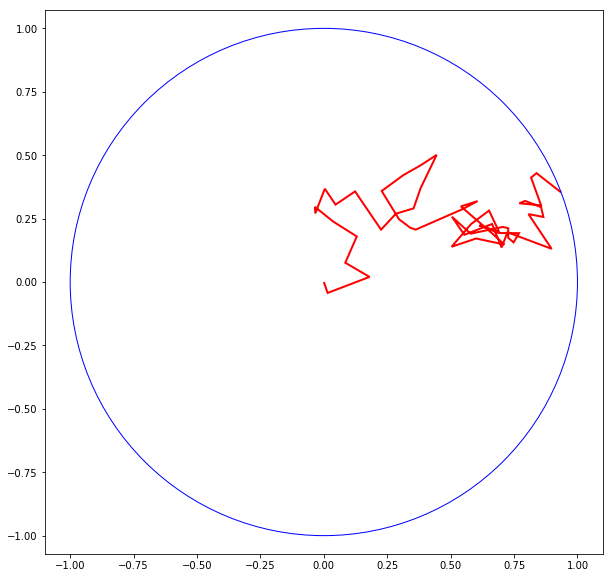

In [6]:
%matplotlib inline
from matplotlib.path import Path
import matplotlib.patches as patches

fig, axes = plt.subplots(figsize=(10,10));

path = Path(pt);

patch = patches.PathPatch(path, facecolor='none',edgecolor='r', lw=2);
axes.add_patch(patch);
axes.add_patch(patches.Circle((0.0,0.0),1,lw=1,ec='b',fill=False));

axes.axis('equal');

Now introduce an additional function to compute the term in the expectation for a given path:

In [10]:
def mc_score(mu_mc,sigma_mc,x0_mc,dt_mc,g_mc,h_mc):
    """Simulate a path and output the score."""
    
    pt, length = mc_path(mu_mc,sigma_mc,x0_mc,dt_mc);
    tot = 0.0;
    if length >0:
        for i in range(1,length):
            tot = tot + h_mc(pt[i]);
    
        tot = tot+(h_mc(pt[0])+h_mc(pt[length]))/2.0;
        tot = tot*dt;
    
        tot = tot+g_mc(pt[length]);
    else:
        tot = g_mc(pt[0]);
    
    return tot

Running a single simulation, and printing the score, we get:

In [11]:
score = mc_score(mu,sigma,(0.0,0.0),dt,g,h)

print(score)

0.6776158281136497


Now lets try a larger number of simulations.

0.18300997939852587


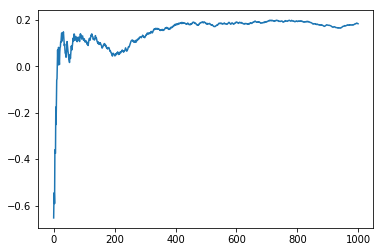

In [14]:
M = 1000;

tot = 0.0;
av = zeros(M);

for i in range(1,M+1):
    tot = tot + mc_score(mu,sigma,(0,0.5),dt,g,h);
    av[i-1] = tot/i;

plt.plot(av)

print(av[M-1])

Let's turn this into a function:

In [16]:
def mc_pde_solve(mu_mc,sigma_mc,x0_mc,dt_mc,g_mc,h_mc,M):
    """Solve the PDE by Monte Carlo with M simulations"""
    tot = 0.0;

    for i in range(1,M+1):
        tot = tot + mc_score(mu_mc,sigma_mc,x0_mc,dt_mc,g_mc,h_mc);
        
    return tot/M;

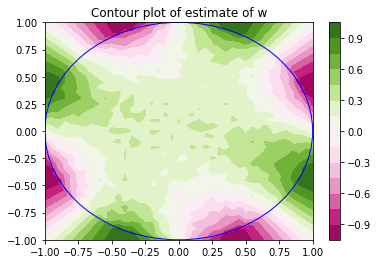

In [17]:
#Plot 'solution' as a colormap; code taken from: 
# http://matplotlib.org/examples/images_contours_and_fields/pcolormesh_levels.html

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dx, dy = 0.05, 0.05;
M2 = 200;

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-1.0, 1.0 + dy, dy),
                slice(-1.0, 1.0 + dx, dx)]

z = zeros(shape(x));

it = np.nditer(x, flags=['multi_index'])
while not it.finished:
    z[it.multi_index] = mc_pde_solve(mu,sigma,
                                     (x[it.multi_index],y[it.multi_index]),
                                     dt,g,h,M2);
    it.iternext();

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots()

cf = ax1.contourf(x,y, z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('Contour plot of estimate of w')

ax1.add_patch(patches.Circle((0.0,0.0),1,lw=1,ec='b',fill=False));

plt.show()



As you can see, the solution is strongly influenced by the boundary conditions, with a slight directional preference from the NW corner to the SE corner, potentially due to the drift. Since each point's estimate is subject to variance, and we are not taking many samples for each point, there is some fluctuation in the interior, which leads to the 'rough' nature of the solution

Of course, there are much better deterministic methods for solving PDEs such as this one, which will runmuch faster. The Monte Carlo methods strengths come to the fore when we want to solve systems in high dimensions. The convergence rate of the Monte Carlo will always be of order $N^{-1/2}$, independent of the dimension of the PDE, since the error is controlled by the Central Limit Theorem, which tells us that the error is normally distributed, with variance proportional to $N^{-1/2}$.

Other advantages of Monte Carlo methods include its ease of implementation (most of the code above relates to the plotting of the figures!), which can be important for more complicated problems, and the fact that these methods have generalisations to significantly more complicated PDEs (for example, many semi-linear PDEs can be handled using variants of these methods).